# Theme Setup

In [301]:
# List Jupyter Theme
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [302]:
# toggle toolbar ON and notebook name ON
!jt -t grade3 -T -N

# Load Packages & Track Versions

In [303]:
# check the versions of key python librarise
# Python
import sys
import platform
print('python: %s' % platform.python_version())

python: 3.6.5


In [304]:
pkgs = [
    'numpy', 'matplotlib', 'pandas', 'statsmodels', 'sklearn', 'fbprophet',
    'numba'
]
for pkg in pkgs:
    try:
        globals()['est_module'] = __import__(pkg)
        print(pkg, ': %s' % est_module.__version__)
    except ModuleNotFoundError:
        print(pkg, 'Not Found')

numpy : 1.14.5
matplotlib : 2.2.2
pandas : 0.23.1
statsmodels : 0.9.0
sklearn : 0.19.1
fbprophet : 0.3
numba : 0.39.0


In [305]:
import os
workspace_dir = os.path.realpath('..')
print('Workspace Dir ->',workspace_dir )

Workspace Dir -> /home/rajasoun/workspace/scripts


In [306]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt

import datetime
from numba import jit
import math

In [307]:
%matplotlib inline

# Functions

In [308]:
def group_by_col(df, col):
    group = df.groupby(df[str(col)])
    group_by = pd.DataFrame(group.size().reset_index(name="Count"))
    return group_by

In [309]:
def delete_columns(df, cols):
    df = df.drop(list(cols), axis=1)
    return df

In [310]:
def print_cols_type(df):
    # Print Column Type
    for col in df:
        print(str(col), '->', type(df[col][1]))

In [311]:
def coerce_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [312]:
import dateutil
# Convert date from string to date times
def coerce_columns_to_date(df, col):
    df[str(col)] = df[str(col)].apply(dateutil.parser.parse, dayfirst=True)

In [313]:
#function to create a DataFrame in the format required by Prophet
def create_df_for_prophet(ts):
    ts.columns = ["ds", "y"]
    ts = ts.dropna()
    ts.reset_index(drop=True, inplace=True)
    return ts

In [314]:
from scipy import stats
import numpy as np
dir_name = workspace_dir + '/data/output/'


def remove_outliers_by_col(df, col):
    file = dir_name + 'outliers_' + str(col).lower() + '.csv'
    z = np.abs(stats.zscore(df[str(col)]))
    threshold = 3
    df[(z > 3)].to_csv(file, index=False)
    print('Removed Outliers Stores In ->', file)
    return df[(z < 3)]

In [315]:
import seaborn as sns


def visualize_outliers_by_col(df, col):
    sns.boxplot(x=df[str(col)])

In [316]:
#function to remove any negative forecasted values.
def remove_negtives(ts):
    ts['yhat'] = ts['yhat'].clip_lower(0)
    ts['yhat_lower'] = ts['yhat_lower'].clip_lower(0)
    ts['yhat_upper'] = ts['yhat_upper'].clip_lower(0)
    return ts

In [317]:
import math


def mse(y_actual, y_pred):
    # compute the mean square error
    mse = ((y_actual - y_pred)**2).mean()
    return mse

In [318]:
# Symmetric Mean Absolute Percent Error (SMAPE)
#function to calculate in sample SMAPE scores
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        if (y_true[i] != None and np.isnan(y_true[i]) == False):
            a = y_true[i]
            b = y_pred[i]
            c = a + b
            if c == 0:
                continue
            out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

# Sanity Check - Input Data

In [319]:
#import required data
from subprocess import check_output
input_dir = workspace_dir + "/data/input/"
print(check_output(["ls", input_dir ]).decode("utf8"))

est_daily_access.csv
est_hourly_access.csv
us_holidays.csv



# Predict - From Google Analytics Data

## Load & Clean Up Data

In [358]:
max_date_past_data = '2018-08-28' #str(clean_ga_data.ds.max().date())
data_file = workspace_dir + "/data/input/est_daily_access.csv"
ga_data = pd.read_csv(data_file)
m = ga_data.shape[0]
n = ga_data.shape[1]

print('        Data Set Details')
print('+++++++++++++++++++++++++++++++')
print('# Of Observations', str(m))
print('# Of Features', str(n))

        Data Set Details
+++++++++++++++++++++++++++++++
# Of Observations 2194
# Of Features 2


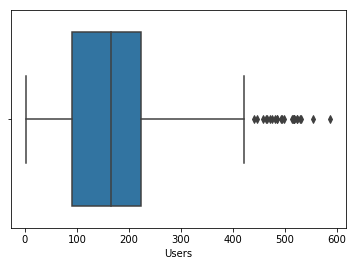

In [359]:
visualize_outliers_by_col(ga_data, 'Users')

In [360]:
ga_data = remove_outliers_by_col(ga_data, 'Users')
m = ga_data.shape[0]
print(' Data Set without Outliers')
print('+++++++++++++++++++++++++++++++')
print('# Of Observations', str(m))
ga_data.tail()

Removed Outliers Stores In -> /home/rajasoun/workspace/scripts/data/output/outliers_users.csv
 Data Set without Outliers
+++++++++++++++++++++++++++++++
# Of Observations 2170


,Day,Users
2189,8/26/18,41
2190,8/27/18,119
2191,8/28/18,149
2192,8/29/18,174
2193,8/30/18,156


In [361]:
clean_ga_data = create_df_for_prophet(ga_data)
coerce_df_columns_to_numeric(clean_ga_data, ['y'])
coerce_columns_to_date(clean_ga_data,'ds')
print_cols_type(clean_ga_data)
clean_ga_data.tail()

ds -> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
y -> <class 'numpy.int64'>


,ds,y
2165,2018-08-26,41
2166,2018-08-27,119
2167,2018-08-28,149
2168,2018-08-29,174
2169,2018-08-30,156


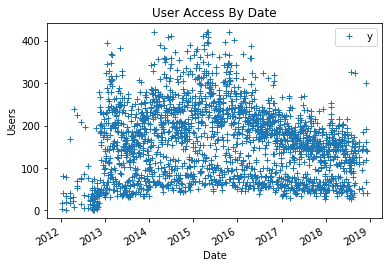

In [362]:
clean_ga_data.set_index('ds').plot(style=['+'])
plt.xlabel('Date')
plt.ylabel('Users')
plt.title('User Access By Date')
plt.show()

In [363]:
# log transform data
ga_data['y'] = np.log(ga_data['y'])
ga_data.tail()

,ds,y
2189,8/26/18,3.713572
2190,8/27/18,4.779123
2191,8/28/18,5.003946
2192,8/29/18,5.159055
2193,8/30/18,5.049856


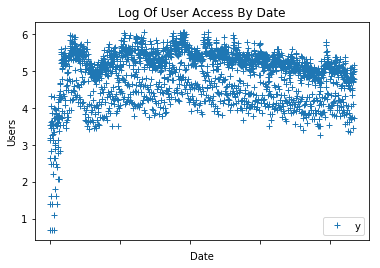

In [364]:
ga_data.set_index('ds').plot(style=['+'])
plt.xlabel('Date')
plt.ylabel('Users')
plt.title('Log Of User Access By Date')
plt.show()

## Prediction

In [365]:
holidays_csv = workspace_dir + "/data/input/us_holidays.csv"
us_public_holidays = pd.read_csv(holidays_csv)
mdl = Prophet(
    interval_width=0.95,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=us_public_holidays)
mdl.fit(ga_data)

ga_future = mdl.make_future_dataframe(
    periods=31 + 28, freq='D', include_history=True)
ga_forecast = mdl.predict(ga_future)

In [366]:
ga_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2224,2018-10-24,4.924071,4.456183,5.399536
2225,2018-10-25,4.911525,4.409547,5.405308
2226,2018-10-26,4.807742,4.307727,5.267937
2227,2018-10-27,3.985925,3.491291,4.477732
2228,2018-10-28,3.580551,3.096209,4.052847


In [367]:
np.exp(ga_forecast[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
2224,137.561451,86.158049,221.303643
2225,135.846419,82.232215,222.584742
2226,122.454835,74.271505,194.015270
2227,53.835080,32.828300,88.034740
2228,35.893316,22.113952,57.561089


In [368]:
ga_forecast = remove_negtives(ga_forecast)

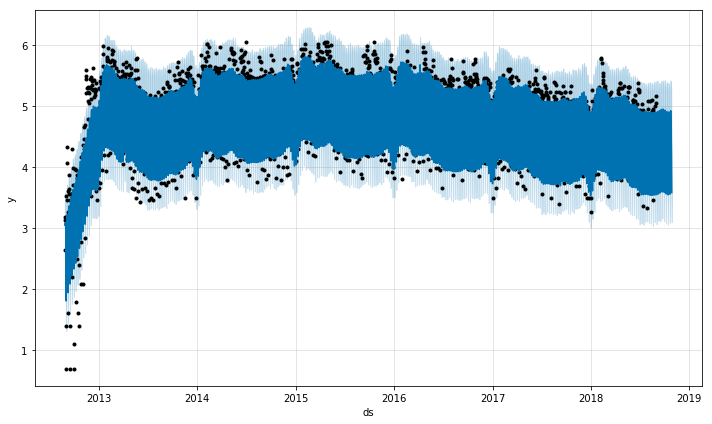

In [369]:
mdl.plot(ga_forecast)
plt.show()

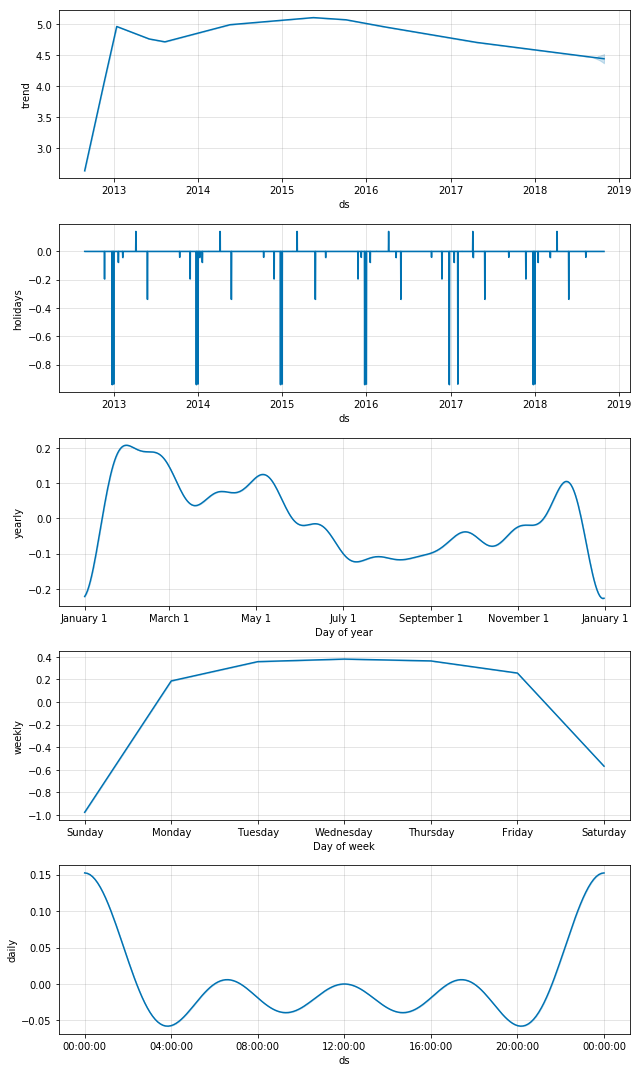

In [370]:
# plot time series components
mdl.plot_components(ga_forecast)
plt.show()

In [371]:
ga_forecast['yhat'] = np.exp(ga_forecast[['yhat']])
ga_forecast['yhat_lower'] = np.exp(ga_forecast[['yhat_lower']])
ga_forecast['yhat_upper'] = np.exp(ga_forecast[['yhat_upper']])

ga_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2224,2018-10-24,137.561451,86.158049,221.303643
2225,2018-10-25,135.846419,82.232215,222.584742
2226,2018-10-26,122.454835,74.271505,194.015270
2227,2018-10-27,53.835080,32.828300,88.034740
2228,2018-10-28,35.893316,22.113952,57.561089


In [372]:
modelling_csv = workspace_dir + "/data/output/prediction_based_ga_modelling.csv"
ga_forecast.to_csv(modelling_csv)

In [373]:
# retransform using e
y_hat = ga_forecast['yhat'][:]
y_true = clean_ga_data['y']
mse = mse(y_hat, y_true)
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

TypeError: 'numpy.float64' object is not callable

In [374]:
y_prediction = ga_forecast['yhat'][:]
y_actual = clean_ga_data['y']
smape = smape_fast(y_actual.values, y_prediction.values)
print('Prediction quality: SMAPE :  {:.2f}  '.format(smape))

Prediction quality: SMAPE :  17.32  


In [375]:
prediction = ga_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
column_headers = [
    'Date', 'PredictedUser', 'Lower(PredictedUser)', 'Upper(PredictedUser)'
]
prediction.columns = column_headers
forecast_csv = workspace_dir + '/data/output/forecast_for_future.csv'
prediction_future = prediction[prediction.Date > max_date_past_data]
prediction_future.to_csv(forecast_csv, index=False)
prediction_future.tail()

,Date,PredictedUser,Lower(PredictedUser),Upper(PredictedUser)
2224,2018-10-24,137.561451,86.158049,221.303643
2225,2018-10-25,135.846419,82.232215,222.584742
2226,2018-10-26,122.454835,74.271505,194.015270
2227,2018-10-27,53.835080,32.828300,88.034740
2228,2018-10-28,35.893316,22.113952,57.561089


In [376]:
ds = ga_forecast[['ds']]
actual = clean_ga_data['y']
forecast = ga_forecast[['yhat', 'yhat_lower', 'yhat_upper']]
frames = [ds, actual, forecast]
column_headers = [
    'Date', 'ActualUser', 'PredictedUser', 'Lower(PredictedUser)',
    'Upper(PredictedUser)'
]
result = pd.concat(frames, axis=1, join='inner')
result.columns = column_headers
forecast_csv = workspace_dir + '/data/output/forecast_for_past.csv'
result.to_csv(forecast_csv, index=False)
result.tail()

,Date,ActualUser,PredictedUser,Lower(PredictedUser),Upper(PredictedUser)
2165,2018-08-26,41,34.499010,22.092896,56.697764
2166,2018-08-27,119,110.582445,68.289072,177.410703
2167,2018-08-28,149,131.275724,79.262756,210.038512
2168,2018-08-29,174,134.360062,85.105208,222.273246
2169,2018-08-30,156,132.268036,80.643729,208.499842


In [378]:
#!jupyter nbconvert --to script *.ipynb